# The K-profile parameterization in `OceanTurb.jl`

Here we demonstrate how to set up a `Model` in `OceanTurb.jl`, set initial conditions and boundary conditions, and iterate the model forward.

In [5]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot, PyPlotPlus, Printf

import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)
plot(op::Function, f::Field, args...; kwargs...) = plot(op.(data(f)), nodes(f), args...; kwargs...)

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


plot (generic function with 3 methods)

# Pure convection

Next, we set up a 'pure convection' problem in `OceanTurb.KPP`.
This problem is characterized by

* a constant flux boundary condition for temperature at the top
* a stable, linear temperature initial condition
* zero initial conditions for other variables

In [6]:
# First, we define a model 100 m deep with 1m spacing.
parameters = KPP.Parameters()
model = KPP.Model(N=100, L=100.0, parameters=parameters, stepper=:BackwardEuler)

# Initial condition
γ = 0.01
T₀(z) = 20 + γ*z
N₀ = sqrt(model.constants.g*model.constants.α*γ)

# Set T to the function T0(z)
model.solution.T = T₀

heat_flux = 75
temperature_flux = heat_flux / (model.constants.ρ₀ * model.constants.cP)
buoyancy_flux = temperature_flux * model.constants.g * model.constants.α

model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
model.bcs.T.bottom = GradientBoundaryCondition(γ)

# b_t = F_x => F = [m^2 / s^3]; t ~ (F / L^2)^(1/3). F / N^3 = [m^2]
@printf("""
         buoyancy time-scale: %.2f hours
    10 meter flux time-scale: %.2f hours
""", 1 / N₀ / 3600, (10^2 / buoyancy_flux)^(1/3) / 3600)

         buoyancy time-scale: 0.06 hours
    10 meter flux time-scale: 0.36 hours


t: 60.00 minutes, mixing layer depth: 5.95
t: 120.00 minutes, mixing layer depth: 7.42
t: 180.00 minutes, mixing layer depth: 8.47
t: 240.00 minutes, mixing layer depth: 9.36
t: 300.00 minutes, mixing layer depth: 10.20
t: 360.00 minutes, mixing layer depth: 10.75
t: 420.00 minutes, mixing layer depth: 11.31
t: 480.00 minutes, mixing layer depth: 12.00
t: 540.00 minutes, mixing layer depth: 12.31


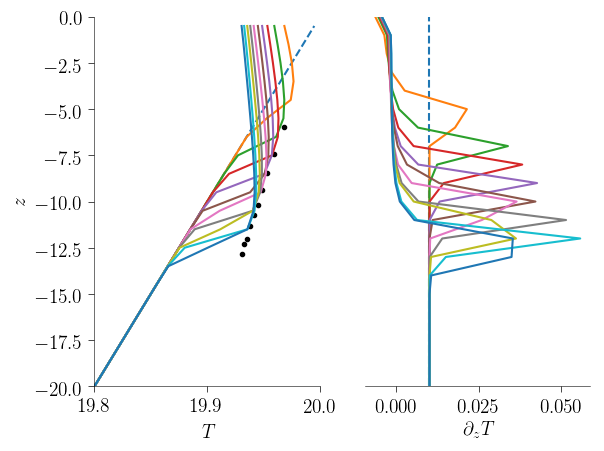

t: 600.00 minutes, mixing layer depth: 12.85


In [7]:
# Time stepping
dt = 1 # seconds
nt = ceil(Int, 3600 / dt) # plot every hour
ni = 10

# Keep track of boundary layer depth versus time
h = [0.0]
t = [0.0]

# Re-initialize plotting and iterating
fig, axs = subplots(ncols=2, sharey=true)

model.solution.T = T₀
U, V, T, S = model.solution
Tz = ∂z(T)
reset!(model.clock)

sca(get(axs, 0))
ylim(-20, 0)
xlim(19.8, 20)
cornerspines()
xlabel(L"T")
ylabel(L"z")

plot(T, "--", label="initial condition")

sca(get(axs, 1))
bottomspine()
get(axs, 1).tick_params(left=false, labelleft=false)
xlabel(L"\partial_z T")

plot(Tz, "--", label="initial condition")

# Iterate
for i = 1:ni
    iterate!(model, dt, nt)
    
    push!(h, model.state.h)
    push!(t, time(model))
    
    @printf("t: %.2f minutes, mixing layer depth: %.2f\n", time(model)/60, model.state.h)
  
    ∂z!(Tz, T)
    
    sca(get(axs, 0))
    plot(T, "-")
    plot(top(T), -model.state.h, "k.")
    
    sca(get(axs, 1))
    plot(Tz, "-")
end

# Boundary layer depth versus time

[Van Roekel et al (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001336)
claims in their equation F11 that in pure convection the mixing layer should deepen according to

$$ h(t) = \sqrt{ \frac{2.8 F_b t}{N^2} } $$

where $F_b$ is the surface buoyancy flux and $N^2 = B_z(t=0)$ is the initial buoyancy gradient.

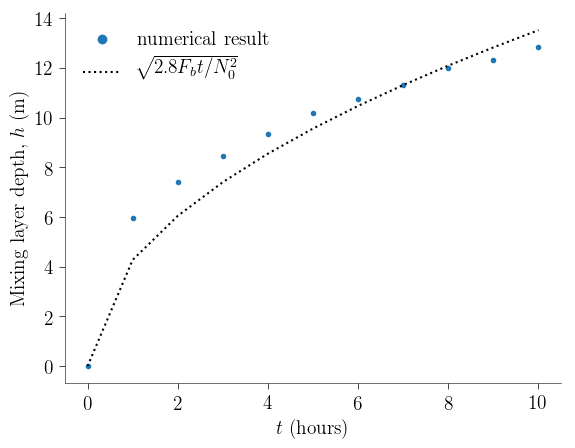

PyObject <matplotlib.legend.Legend object at 0x145e3da58>

In [8]:
fig, axs= subplots()
xlabel("\$t\$ (hours)")
ylabel("Mixing layer depth, \$h\$ (m)")
cornerspines()

h_vanroekel = sqrt.(2.8*buoyancy_flux/N₀^2 * t)

plot(t/3600, h, ".", label="numerical result")
plot(t/3600, h_vanroekel, "k:", label=L"\sqrt{2.8 F_b t / N_0^2}")

legend()